# Learning Bayesian Networks from Data
https://pgmpy.org/detailed_notebooks/10.%20Learning%20Bayesian%20Networks%20from%20Data.html

Previous notebooks showed how Bayesian networks economically encode a probability distribution over a set of variables, and how they can be used e.g. to predict variable states, or to generate new samples from the joint distribution. This section will be about obtaining a Bayesian network, given a set of sample data. Learning a Bayesian network can be split into two problems:

*Parameter learning*: Given a set of data samples and a DAG that captures the dependencies between the variables, estimate the (conditional) probability distributions of the individual variables.

*Structure learning*: Given a set of data samples, estimate a DAG that captures the dependencies between the variables.

This notebook aims to illustrate how parameter learning and structure learning can be done with pgmpy. Currently, the library supports: - Parameter learning for discrete nodes: - Maximum Likelihood Estimation - Bayesian Estimation - Structure learning for discrete, fully observed networks: - Score-based structure estimation (BIC/BDeu/K2 score; exhaustive search, hill climb/tabu search) - Constraint-based structure estimation (PC) - Hybrid structure estimation (MMHC)

## Parameter Learning
Suppose we have the following data:

In [1]:
# Parameter learning: the task to estimate the values of the conditional probability distributions (CPDs), for the variables fruit, size, and tasty.
import pandas as pd
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",],
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                    "yes", "yes", "yes", "yes", "no", "no", "no"],
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
display(data.head(3))
print('data.shape:', data.shape)

,fruit,tasty,size
0,banana,yes,large
1,apple,no,large
2,banana,yes,large


data.shape: (14, 3)


Parameter learning is the task to estimate the values of the conditional probability distributions (CPDs), for the variables fruit, size, and tasty.

# State counts
To make sense of the given data, we can start by counting how often each state of the variable occurs. If the variable is dependent on parents, the counts are done conditionally on the parents states, i.e. for seperately for each parent configuration:

In [2]:
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import ParameterEstimator
model = BayesianNetwork([('fruit', 'tasty'), ('size', 'tasty')])# fruit -> tasty <- size
pe = ParameterEstimator(model, data)
print("\n", pe.state_counts('fruit'))  # unconditional
print("\n", pe.state_counts('tasty'))  # conditional on fruit and size

c:\Users\praf6\OneDrive\UFCA\Ensino\CRAN R_aulas\RClasses\P\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



         count
fruit        
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


## Maximum Likelihood Estimation
A natural estimate for the CPDs is to simply use the relative frequencies, with which the variable states have occured. We observed 7 apples among a total of 14 fruits, so we might guess that about 50% of fruits are apples.

This approach is Maximum Likelihood Estimation (MLE). According to MLE, we should fill the CPDs in such a way, that P(`data`}|`model`) is maximal. This is achieved when using the relative frequencies. See [1], section 17.1 for an introduction to ML parameter estimation. pgmpy supports MLE as follows:

In [3]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional
print(mle.estimate_cpd('tasty'))  # conditional
# mle.get_parameters()#returns a list of CPDs for all variable of the model

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


mle.estimate_cpd(variable) computes the state counts and divides each cell by the (conditional) sample size. The mle.get_parameters()-method returns a list of CPDs for all variable of the model.

The built-in fit()-method of BayesianNetwork provides more convenient access to parameter estimators:

In [4]:
# Similarly to sklearn you can fit all CPDs of `model` using MLE:
model.fit(data, estimator=MaximumLikelihoodEstimator)
print(model.get_cpds('fruit'))  # unconditional
print(model.get_cpds('size'))  # unconditional
print(model.get_cpds('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+-------------+----------+
| size(large) | 0.714286 |
+-------------+----------+
| size(small) | 0.285714 |
+-------------+----------+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


While very straightforward, the ML estimator has the problem of overfitting to the data. In above CPD, the probability of a large banana being tasty is estimated at 0.833, because 5 out of 6 observed large bananas were tasty. Fine. But note that the probability of a small banana being tasty is estimated at 0.0, because we observed only one small banana and it happened to be not tasty. But that should hardly make us certain that small bananas aren’t tasty! We simply do not have enough observations to rely on the observed frequencies. If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off.

When estimating parameters for Bayesian networks, lack of data is a frequent problem. Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation. If a variable has 3 parents that can each take 10 states, then state counts will be done seperately for 10^3 = 1000 parents configurations. This makes MLE very fragile and unstable for learning Bayesian Network parameters. A way to mitigate MLE’s overfitting is Bayesian Parameter Estimation.

## Bayesian Parameter Estimation
The Bayesian Parameter Estimator starts with already existing prior CPDs, that express our beliefs about the variables before the data was observed. Those “priors” are then updated, using the state counts from the observed data. See [1], Section 17.3 for a general introduction to Bayesian estimators.

One can think of the priors as consisting in pseudo state counts, that are added to the actual counts before normalization. Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable.

A very simple prior is the so-called K2 prior, which simply adds 1 to the count of every single state. A somewhat more sensible choice of prior is BDeu (Bayesian Dirichlet equivalent uniform prior). For BDeu we need to specify an equivalent sample size N and then the pseudo-counts are the equivalent of having observed N uniform samples of each variable (and each parent configuration). In pgmpy:

In [ ]:
from pgmpy.estimators import BayesianEstimator
# est = BayesianEstimator(model, data)
# print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))
model.fit(data, estimator=BayesianEstimator, prior_type="BDeu", 
          equivalent_sample_size=10) # default equivalent_sample_size=5
print(model.get_cpds('fruit'))  # unconditional
print(model.get_cpds('size'))  # unconditional
print(model.get_cpds('tasty'))  # conditional

+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+-------------+-----+
| size(large) | 0.7 |
+-------------+-----+
| size(small) | 0.3 |
+-------------+-----+
+------------+--------------------+-----+---------------+---------------+
| fruit      | fruit(apple)       | ... | fruit(banana) | fruit(banana) |
+------------+--------------------+-----+---------------+---------------+
| size       | size(large)        | ... | size(large)   | size(small)   |
+------------+--------------------+-----+---------------+---------------+
| tasty(no)  | 0.2647058823529412 | ... | 0.18          | 0.9           |
+------------+--------------------+-----+---------------+---------------+
| tasty(yes) | 0.7352941176470589 | ... | 0.82          | 0.1           |
+------------+--------------------+-----+---------------+---------------+


The estimated values in the CPDs are now more conservative. In particular, the estimate for a small banana being not tasty is now around 0.64 rather than 1.0. Setting equivalent_sample_size to 10 means that for each parent configuration, we add the equivalent of 10 uniform samples (here: +5 small bananas that are tasty and +5 that aren’t).

## Structure Learning
To learn model structure (a DAG) from a data set, there are two broad techniques:

- score-based structure learning

- constraint-based structure learning

The combination of both techniques allows further improvement: - hybrid structure learning

We briefly discuss all approaches and give examples.

This approach construes model selection as an optimization task. It has two building blocks:

A scoring function $s_D\colon M \to \mathbb R$ that maps models to a numerical score, based on how well they fit to a given data set $D$.

A search strategy to traverse the search space of possible models $M$ and select a model with optimal score.

### Scoring functions
Commonly used scores to measure the fit between model and data are Bayesian Dirichlet scores such as BDeu or K2 and the Bayesian Information Criterion (BIC, also called MDL). See [1], Section 18.3 for a detailed introduction on scores. As before, BDeu is dependent on an equivalent sample size.

In [39]:
import pandas as pd
import numpy as np
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianNetwork

# create random data sample with 3 variables, where Z is dependent on X, Y:
data = pd.DataFrame(np.random.randint(0, 4, size=(5000, 2)), columns=list('XY'))
data['Z'] = data['X'] + data['Y'] #X -> Z <- Y

bdeu = BDeuScore(data, equivalent_sample_size=5)
k2 = K2Score(data)
bic = BicScore(data)

model1 = BayesianNetwork([('X', 'Z'), ('Y', 'Z')])  # X -> Z <- Y (the right model)
model2 = BayesianNetwork([('X', 'Z'), ('X', 'Y')])  # Y <- X -> Z (the wrong model)

#the greater the score the better the model
print('bic.score(model1):', bic.score(model1))
print('bic.score(model2):', bic.score(model2))
print('bdeu.score(model1):', bdeu.score(model1))
print('bdeu.score(model2:', bdeu.score(model2))
print('k2.score(model1):', k2.score(model1))
print('k2.score(model2):', k2.score(model2))


bic.score(model1): -14293.985874656868
bic.score(model2): -20949.730340209437
bdeu.score(model1): -13937.948171731292
bdeu.score(model2: -20905.688098941664
k2.score(model1): -14328.778351289773
k2.score(model2): -20932.514846084498


While the scores vary slightly, we can see that the correct model1 has a much higher score than model2. Importantly, these scores decompose, i.e. they can be computed locally for each of the variables given their potential parents, independent of other parts of the network:

In [40]:
print(bdeu.local_score('Z', parents=[]))
print(bdeu.local_score('Z', parents=['X']))
print(bdeu.local_score('Z', parents=['X', 'Y']))

-9228.18015266147
-6993.513631896803
-57.12121218260944


# Search strategies
The search space of DAGs is super-exponential in the number of variables and the above scoring functions allow for local maxima. The first property makes exhaustive search intractable for all but very small networks, the second prohibits efficient local optimization algorithms to always find the optimal structure. Thus, identifiying the ideal structure is often not tractable. Despite these bad news, heuristic search strategies often yields good results.

If only few nodes are involved (read: less than 5), ExhaustiveSearch can be used to compute the score for every DAG and returns the best-scoring one:

In [41]:
from pgmpy.estimators import ExhaustiveSearch

es = ExhaustiveSearch(data, scoring_method=bic)
best_model = es.estimate()
print(best_model.edges())

print("\nAll DAGs by score:")
for score, dag in reversed(es.all_scores()):
    print(score, ':', dag.edges())

[('X', 'Z'), ('Y', 'Z')]

All DAGs by score:
-14293.985874656868 : [('X', 'Z'), ('Y', 'Z')]
-14329.432879846305 : [('Y', 'Z'), ('Y', 'X'), ('Z', 'X')]
-14329.432879846305 : [('X', 'Z'), ('Y', 'Z'), ('Y', 'X')]
-14329.432879846307 : [('Y', 'X'), ('Z', 'X'), ('Z', 'Y')]
-14329.432879846307 : [('X', 'Y'), ('Z', 'X'), ('Z', 'Y')]
-14329.432879846307 : [('X', 'Y'), ('X', 'Z'), ('Z', 'Y')]
-14329.432879846307 : [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
-16532.36598365125 : [('Y', 'X'), ('Z', 'X')]
-16532.381446693784 : [('X', 'Y'), ('Z', 'Y')]
-18711.350231215056 : [('Y', 'Z'), ('Z', 'X')]
-18711.35023121506 : [('Z', 'X'), ('Z', 'Y')]
-18711.35023121506 : [('X', 'Z'), ('Z', 'Y')]
-20914.28333502 : [('Z', 'X')]
-20914.28333502 : [('X', 'Z')]
-20914.298798062537 : [('Z', 'Y')]
-20914.298798062537 : [('Y', 'Z')]
-20949.730340209437 : [('X', 'Z'), ('Y', 'X')]
-20949.730340209437 : [('X', 'Y'), ('X', 'Z')]
-20949.73034020944 : [('X', 'Y'), ('Z', 'X')]
-20949.74580325197 : [('Y', 'Z'), ('Y', 'X')]
-209

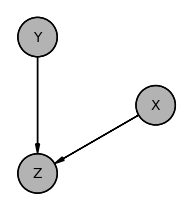

In [42]:
import matplotlib.pyplot as plt
# Get a daft object.
model_daft = best_model.to_daft(node_pos = 'circular', latex=False)
# To open the plot
model_daft.render();
# Save the plot
# model_daft.savefig('sachs.png')

Once more nodes are involved, one needs to switch to heuristic search. HillClimbSearch implements a greedy local search that starts from the DAG start (default: disconnected DAG) and proceeds by iteratively performing single-edge manipulations that maximally increase the score. The search terminates once a local maximum is found.

best_model: [('A', 'H'), ('B', 'A'), ('C', 'A'), ('G', 'H')]


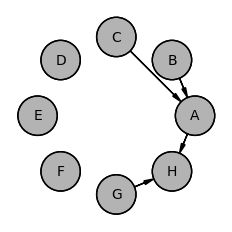

In [43]:
from pgmpy.estimators import HillClimbSearch

# create some data with dependencies
data2 = pd.DataFrame(np.random.randint(0, 3, size=(2500, 8)), columns=list('ABCDEFGH'))
data2['A'] += data2['B'] + data2['C'] #[(B,A), (C,A)]
data2['H'] = data2['G'] - data2['A']#[(G,H), (A,H)]

hc = HillClimbSearch(data2)
best_model = hc.estimate(scoring_method=BicScore(data2), show_progress=False)
print('best_model:', best_model.edges())
model_daft = best_model.to_daft(node_pos = 'circular', latex=False)
model_daft.render();

To enforce a wider exploration of the search space, the search can be enhanced with a tabu list. The list keeps track of the last n modfications; those are then not allowed to be reversed, regardless of the score. Additionally a white_list or black_list can be supplied to restrict the search to a particular subset or to exclude certain edges. The parameter max_indegree allows to restrict the maximum number of parents for each node.

## Constraint-based Structure Learning
A different, but quite straightforward approach to build a DAG from data is this:

- Identify independencies in the data set using hypothesis tests

- Construct DAG (pattern) according to identified independencies

### (Conditional) Independence Tests
Independencies in the data can be identified using chi2 conditional independence tests. To this end, a conditional independence hypothesis test is performed to check if X is independent from Y given a set of variables Zs:

In [48]:
from pgmpy.estimators import PC
from pgmpy.estimators.CITests import chi_square

data2['A'] += data2['B'] + data2['C'] #[(B,A), (C,A)]
data2['H'] = data2['G'] - data2['A']#[(G,H), (A,H)]
data2['E'] *= data2['F'] # [(F, A)] - NONLINEAR RELATIONSHIP
print('(B,A): ', chi_square(X='B', Y='A', Z=[], data=data2, significance_level=0.05))          # dependent
print('(B,H): ', chi_square(X='B', Y='H', Z=[], data=data2, significance_level=0.05))          # dependent
print('(B,E): ', chi_square(X='B', Y='E', Z=[], data=data2, significance_level=0.05))          # independent
print('(B,H|A): ', chi_square(X='B', Y='H', Z=['A'], data=data2, significance_level=0.05))       # independent
print('(A,G): ', chi_square(X='A', Y='G', Z=[], data=data2, significance_level=0.05))          # independent
print('(A,G|H): ', chi_square(X='A', Y='G', Z=['H'], data=data2, significance_level=0.05))       # dependent

(B,A):  False
(B,H):  False
(B,E):  True
(B,H|A):  True
(A,G):  True
(A,G|H):  False


The CITests.py module in pgmpy implements a few possible conditional independence tests.

### DAG (pattern) construction
With a method for independence testing at hand, we can construct a DAG from the data set in three steps: 1. Construct an undirected skeleton - estimate_skeleton() 2. Orient compelled edges to obtain partially directed acyclid graph (PDAG; I-equivalence class of DAGs) - skeleton_to_pdag() 3. Extend DAG pattern to a DAG by conservatively orienting the remaining edges in some way - pdag_to_dag()

Step 1.&2. form the so-called PC algorithm, see [2], page 550. PDAGs are DirectedGraphs, that may contain both-way edges, to indicate that the orientation for the edge is not determined.

Working for n conditional variables: 3:  60%|██████    | 3/5 [00:00<00:00, 16.08it/s]

Undirected edges:  [('A', 'H'), ('E', 'F'), ('G', 'H')]
PDAG edges:        [('G', 'H'), ('A', 'H'), ('F', 'E'), ('E', 'F')]
DAG edges:         [('G', 'H'), ('A', 'H'), ('E', 'F')]


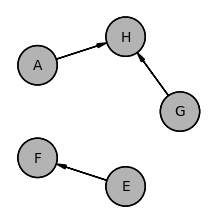

In [52]:
est = PC(data2)
skel, seperating_sets = est.build_skeleton(significance_level=0.05)
print("Undirected edges: ", skel.edges())
pdag = est.skeleton_to_pdag(skel, seperating_sets)
print("PDAG edges:       ", pdag.edges())
best_model = pdag.to_dag()
print("DAG edges:        ", best_model.edges())
model_daft = best_model.to_daft(node_pos = 'circular', latex=False)
model_daft.render();

The estimate()-method provides a shorthand for the three steps above and directly returns a BayesianModel:

In [53]:
print(est.estimate(significance_level=0.01).edges())

Working for n conditional variables: 3:  60%|██████    | 3/5 [00:00<00:00, 18.97it/s]

[('G', 'H'), ('A', 'H'), ('E', 'F')]


PC PDAG construction is only guaranteed to work under the assumption that the identified set of independencies is faithful, i.e. there exists a DAG that exactly corresponds to it. Spurious dependencies in the data set can cause the reported independencies to violate faithfulness. It can happen that the estimated PDAG does not have any faithful completions (i.e. edge orientations that do not introduce new v-structures). In that case a warning is issued.

## Hybrid Structure Learning
The MMHC algorithm [3] combines the constraint-based and score-based method. It has two parts:

1. Learn undirected graph skeleton using the constraint-based construction procedure MMPC

2. Orient edges using score-based optimization (BDeu score + modified hill-climbing)

We can perform the two steps seperately, more or less as follows:

In [55]:
#[(B,A), (C,A)]
#[(G,H), (A,H)]
# [(F, A)] - NONLINEAR RELATIONSHIP
from pgmpy.estimators import MmhcEstimator
from pgmpy.estimators import BDeuScore

mmhc = MmhcEstimator(data2)
skeleton = mmhc.mmpc()
print("Part 1) Skeleton: ", skeleton.edges())

# use hill climb search to orient the edges:
hc = HillClimbSearch(data2)
model = hc.estimate(tabu_length=10, white_list=skeleton.to_directed().edges(), scoring_method=BDeuScore(data))
print("Part 2) Model:    ", model.edges())


Part 1) Skeleton:  [('A', 'H'), ('A', 'F'), ('A', 'D'), ('B', 'H'), ('B', 'F'), ('C', 'D'), ('C', 'E'), ('D', 'H'), ('E', 'F'), ('E', 'G'), ('F', 'H'), ('G', 'H')]


  0%|          | 0/1000000 [00:00<?, ?it/s]


KeyError: 'B'

# References
[1] Koller & Friedman, Probabilistic Graphical Models - Principles and Techniques, 2009

[2] Neapolitan, Learning Bayesian Networks, 2003

[3] Tsamardinos et al., The max-min hill-climbing BN structure learning algorithm, 2005